### Importing Libraries   

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    confusion_matrix, classification_report
)

###  Train Data Preprocessing 

In [3]:
# Configuration
ROOT_DATASET_DIR = '/kaggle/input/s-2025-multi-class-pretraied-network-project/Data/Train'
OUTPUT_NPY_IMAGES = 'images.npy'
OUTPUT_NPY_LABELS = 'labels.npy'
IMG_SIZE = (160, 160)  #
# 1. Discover class folders and map to integer labels
class_dirs = sorted(
    d for d in os.listdir(ROOT_DATASET_DIR)
    if os.path.isdir(os.path.join(ROOT_DATASET_DIR, d))
)
label_map = {}
for d in class_dirs:
    try:
        lbl = int(d)           # folder '0'->0, '14'->14, '-1'->-1
    except ValueError:
        raise ValueError(f"Folder name '{d}' is not an integer label!")
    label_map[d] = lbl

# 2. Gather image paths and labels
image_paths = []
labels = []
for folder_name in class_dirs:
    lbl = label_map[folder_name]
    folder_path = os.path.join(ROOT_DATASET_DIR, folder_name)
    for fn in os.listdir(folder_path):
        if fn.lower().endswith(('.png', '.jpg', 'jpeg', '.bmp', '.gif')):
            image_paths.append(os.path.join(folder_path, fn))
            labels.append(lbl)

num_images = len(image_paths)
print(f"Found {num_images} images.")

# 3. Pre-allocate arrays
images_array = np.zeros((num_images, IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.uint8)
labels_array = np.array(labels, dtype=np.int32)

# 4. Load and resize images into the array
for i, img_path in enumerate(tqdm(image_paths, desc='Processing images')):
    try:
        img = Image.open(img_path).convert('RGB')
        img = img.resize(IMG_SIZE, Image.LANCZOS)
        images_array[i] = np.array(img)
    except Exception as e:
        print(f"[!] Skipped {img_path}: {e}")

# 5. Save as .npy files
np.save(OUTPUT_NPY_IMAGES, images_array)
np.save(OUTPUT_NPY_LABELS, labels_array)
print(f"✅ Saved {OUTPUT_NPY_IMAGES} and {OUTPUT_NPY_LABELS}")


Found 4587 images.


Processing images: 100%|██████████| 4587/4587 [00:38<00:00, 117.94it/s]


✅ Saved images.npy and labels.npy


### Model Training

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


🚀 Starting training...

--- Phase 1: FC Head Training ---
[Head] Epoch 1 - Train Loss: 2.0253 | Val Loss: 1.5931 | Val Acc: 46.51%
[Head] Epoch 2 - Train Loss: 1.7307 | Val Loss: 1.4639 | Val Acc: 48.15%
[Head] Epoch 3 - Train Loss: 1.5940 | Val Loss: 1.3507 | Val Acc: 52.83%
[Head] Epoch 4 - Train Loss: 1.5593 | Val Loss: 1.3722 | Val Acc: 54.68%
[Head] Epoch 5 - Train Loss: 1.4832 | Val Loss: 1.2966 | Val Acc: 54.25%
[Head] Epoch 6 - Train Loss: 1.4717 | Val Loss: 1.3073 | Val Acc: 52.72%
[Head] Epoch 7 - Train Loss: 1.4790 | Val Loss: 1.2286 | Val Acc: 56.54%
[Head] Epoch 8 - Train Loss: 1.4265 | Val Loss: 1.2507 | Val Acc: 56.86%
[Head] Epoch 9 - Train Loss: 1.3798 | Val Loss: 1.2061 | Val Acc: 58.17%
[Head] Epoch 10 - Train Loss: 1.3787 | Val Loss: 1.2425 | Val Acc: 59.04%
[Head] Epoch 11 - Train Loss: 1.3669 | Val Loss: 1.2247 | Val Acc: 57.63%
[Head] Epoch 12 - Train Loss: 1.3542 | Val Loss: 1.3102 | Val Acc: 53.59%
[Head] Epoch 13 - Train Loss: 1.3316 | Val Loss: 1.1931 | Val A

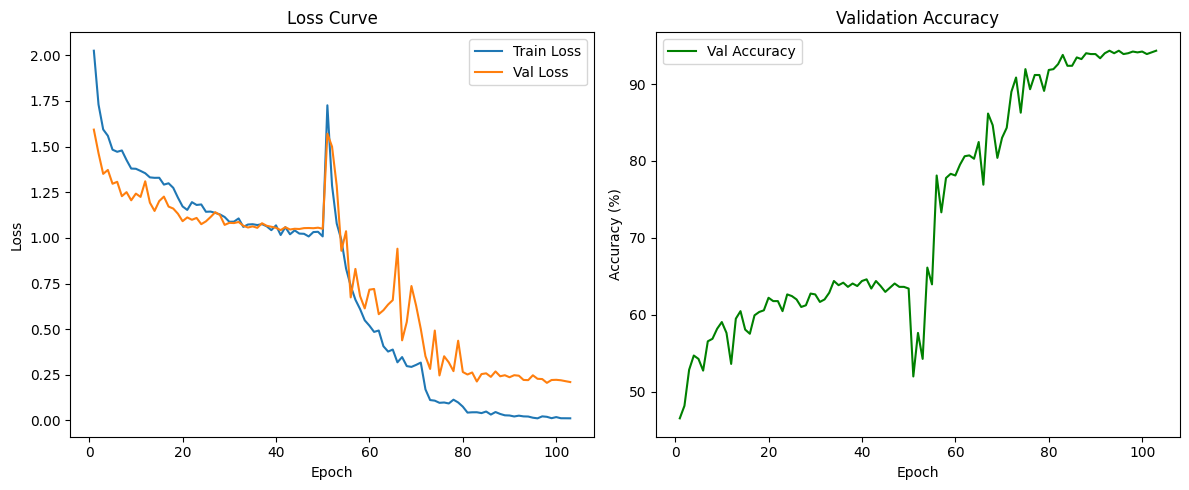

✅ Training completed and best model saved as 'best_model.pth'


In [10]:
# --- 1) CONFIGURATION ------------------------------------------------------
IMAGES_PATH   = 'images.npy'
LABELS_PATH   = 'labels.npy'
NUM_CLASSES   = 16
BATCH_SIZE    = 32
IMAGE_SIZE    = (160, 160)
EPOCHS_PHASE1 = 50
EPOCHS_PHASE2 = 100
EARLY_STOPPING_PATIENCE = 10
BEST_MODEL_PATH = 'best_model.pth'

# 2) AUGMENTATION PIPELINES 
train_transform = A.Compose([
    A.RandomResizedCrop(size=(160, 160), scale=(0.8, 1.0), ratio=(0.9, 1.1), p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.HueSaturationValue(p=0.3),
    A.Rotate(limit=30, p=0.4),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# 3) DATASET 
class NumpyDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        labels = np.where(labels == -1, NUM_CLASSES - 1, labels)  # Handle '-1' as last class
        self.images = images
        self.labels = labels.astype(np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        lbl = self.labels[idx]
        if self.transform:
            img = self.transform(image=img)['image']
        return img, lbl

# 4) MODEL SETUP 
def create_model():
    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, NUM_CLASSES)
    )
    return model

# 5) EARLY STOPPING 
class EarlyStopping:
    def __init__(self, patience=EARLY_STOPPING_PATIENCE):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_acc):
        if self.best_score is None or val_acc > self.best_score:
            self.best_score = val_acc
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# 6) TRAIN / VALID LOOP
import matplotlib.pyplot as plt

def train_model():
    images = np.load(IMAGES_PATH)
    labels = np.load(LABELS_PATH)
    labels = np.where(labels == -1, NUM_CLASSES - 1, labels)

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, val_idx = next(sss.split(images, labels))

    train_ds = NumpyDataset(images[train_idx], labels[train_idx], transform=train_transform)
    val_ds   = NumpyDataset(images[val_idx],   labels[val_idx],   transform=val_transform)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = create_model().to(device)
    criterion = nn.CrossEntropyLoss()

    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    # ------------------ Phase 1 ------------------
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True

    optimizer = optim.AdamW(model.fc.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)
    early_stopper = EarlyStopping()
    best_val_acc = 0.0

    print("\n--- Phase 1: FC Head Training ---")
    for epoch in range(EPOCHS_PHASE1):
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(x)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x.size(0)
        train_loss = running_loss / len(train_loader.dataset)

        model.eval()
        correct, total = 0, 0
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                val_loss += criterion(out, y).item() * x.size(0)
                correct += (out.argmax(1) == y).sum().item()
                total += y.size(0)
        val_loss /= len(val_loader.dataset)
        val_acc = 100 * correct / total

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"[Head] Epoch {epoch+1} - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), BEST_MODEL_PATH)

        scheduler.step(val_acc)
        early_stopper(val_acc)
        if early_stopper.early_stop:
            print("Early stopping in Phase 1.")
            break

    # ------------------ Phase 2 ------------------
    for param in model.parameters():
        param.requires_grad = True

    optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)
    early_stopper = EarlyStopping()

    print("\n--- Phase 2: Full Fine-Tuning ---")
    for epoch in range(EPOCHS_PHASE2):
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(x)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x.size(0)
        train_loss = running_loss / len(train_loader.dataset)

        model.eval()
        correct, total = 0, 0
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                val_loss += criterion(out, y).item() * x.size(0)
                correct += (out.argmax(1) == y).sum().item()
                total += y.size(0)
        val_loss /= len(val_loader.dataset)
        val_acc = 100 * correct / total

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"[Fine] Epoch {epoch+1} - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), BEST_MODEL_PATH)

        scheduler.step(val_acc)
        early_stopper(val_acc)
        if early_stopper.early_stop:
            print("Early stopping in Phase 2.")
            break

    print(f"✅ Training complete. Best Val Accuracy: {best_val_acc:.2f}%")

    # 🔥 Save Plots
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_acc'], label='Val Accuracy', color='green')
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.tight_layout()
    plt.savefig("training_curves.png", dpi=300)
    print("📈 Saved training curves → training_curves.png")
    plt.show()

    return model

# 7) RUN TRAINING 
if __name__ == "__main__":
    print("🚀 Starting training...")
    model = train_model()
    print(f"✅ Training completed and best model saved as '{BEST_MODEL_PATH}'")


###  Evaluation

Top-1 Accuracy     : 98.69%
Top-3 Accuracy     : 99.78%
Weighted F1 Score  : 0.9869
Weighted Precision : 0.9872
Weighted Recall    : 0.9869

📄 Per-Class Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        42
           1       0.98      1.00      0.99        42
           2       0.97      1.00      0.99        35
           3       1.00      0.94      0.97        47
           4       1.00      1.00      1.00        34
           5       1.00      1.00      1.00        35
           6       0.97      1.00      0.99        38
           7       0.91      0.97      0.94        30
           8       1.00      0.97      0.98        32
           9       1.00      1.00      1.00        38
          10       1.00      1.00      1.00        34
          11       1.00      0.96      0.98        28
          12       1.00      1.00      1.00        35
          13       1.00      1.00      1.00        42
          14       1.00     

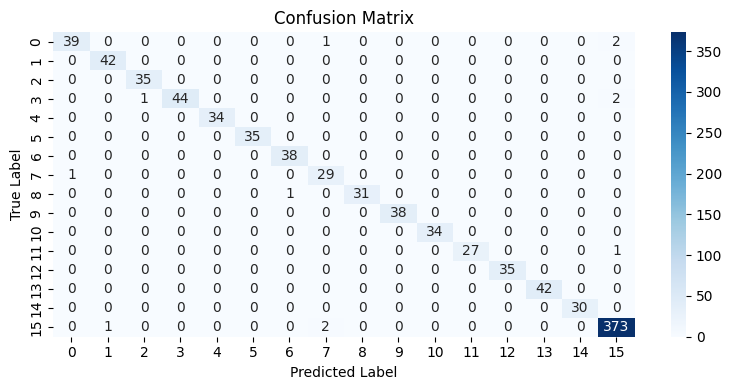

In [11]:
# Configuration
IMAGES_PATH = 'images.npy'
LABELS_PATH = 'labels.npy'
NUM_CLASSES = 16
IMAGE_SIZE = (160, 160)
BATCH_SIZE = 32
CLASS_NAMES = [str(i) for i in range(NUM_CLASSES)]  # Replace with actual class names if available

# Transforms
val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Dataset
class NumpyDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        labels = np.where(labels == -1, NUM_CLASSES - 1, labels)
        self.images = images
        self.labels = labels.astype(np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx].astype(np.float32)
        lbl = self.labels[idx]
        if self.transform:
            img = self.transform(image=img)['image']
        return img, lbl

# Model Definition
def create_model():
    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    in_features = model.fc.in_features
    model.fc = torch.nn.Sequential(
        torch.nn.Linear(in_features, 512),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.3),
        torch.nn.Linear(512, NUM_CLASSES)
    )
    return model

# Evaluation Function
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    top1_correct = 0
    top3_correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds_top1 = outputs.topk(1, dim=1)
            _, preds_top3 = outputs.topk(3, dim=1)

            total += labels.size(0)
            top1_correct += (preds_top1.squeeze() == labels).sum().item()
            top3_correct += sum([labels[i] in preds_top3[i] for i in range(labels.size(0))])

            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Metrics
    top1_acc = top1_correct / total
    top3_acc = top3_correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted')

    print(f"Top-1 Accuracy     : {top1_acc*100:.2f}%")
    print(f"Top-3 Accuracy     : {top3_acc*100:.2f}%")
    print(f"Weighted F1 Score  : {f1:.4f}")
    print(f"Weighted Precision : {precision:.4f}")
    print(f"Weighted Recall    : {recall:.4f}")

    # Classification Report
    print("\n📄 Per-Class Report:")
    print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES, zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png", dpi=300)
    plt.show()

    return top1_acc, top3_acc, f1, precision, recall

# Load Data
images = np.load(IMAGES_PATH)
labels = np.load(LABELS_PATH)
dataset = NumpyDataset(images, labels, transform=val_transform)

# Validation Split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
_, val_ds = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# Load Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model().to(device)
model.load_state_dict(torch.load("best_model.pth", map_location=device))

# Evaluate
top1_acc, top3_acc, f1, precision, recall = evaluate_model(model, val_loader, device)


### Test Data 

In [34]:
# CONFIG 
TEST_DIR        = '/kaggle/input/s-2025-multi-class-pretraied-network-project/Data/Pridect'
MODEL_PATH      = 'cv_projec.pth'
OUTPUT_SUB_CSV  = 'Arooj-F2021065198.csv'
BATCH_SIZE      = 32
IMAGE_SIZE      = (160, 160)
NUM_CLASSES     = 16
DEVICE          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# PREPROCESSING
test_transform = A.Compose([
    A.Resize(*IMAGE_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Fixed std values
    ToTensorV2()
])

# DATASET
class TestDataset(Dataset):
    def __init__(self, test_dir, transform):
        self.test_dir = test_dir
        self.ids = sorted(os.listdir(test_dir))
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, i):
        fn = self.ids[i]
        path = os.path.join(self.test_dir, fn)
        img = np.array(Image.open(path).convert('RGB'))
        img = self.transform(image=img)['image']
        return fn, img

# MODEL LOADING
# Use ResNet50 to match your training
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Replace head exactly as in training
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(512, NUM_CLASSES)
)

# Load trained weights
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE).eval()

# INFERENCE 
ds = TestDataset(TEST_DIR, test_transform)
dl = DataLoader(ds, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)
ids, preds = [], []

with torch.no_grad():
    for batch in dl:
        fns, imgs = batch
        imgs = imgs.to(DEVICE)
        out = model(imgs)
        label_idxs = out.argmax(dim=1).cpu().numpy()
        # Remap class 15 to -1
        label_idxs = [int(l) if l != NUM_CLASSES-1 else -1 for l in label_idxs]
        ids.extend(fns)
        preds.extend(label_idxs)

# SAVE SUBMISSION 
df = pd.DataFrame({'Id': ids, 'Label': preds})
df.to_csv(OUTPUT_SUB_CSV, index=False)
print(f"Saved → {OUTPUT_SUB_CSV} with {len(df)} predictions")

Saved → Arooj-198.csv with 425 predictions
